In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier

### Import & Preprocessing

In [29]:
df = pd.read_csv("heart_disease_prediction.csv")
df = df.rename({'Heart Disease': 'Y'}, axis=1) 
df["Y"].replace({'Absence' : int(0), "Presence" : int(1)}, inplace=True, regex=True)
df.head(10)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Y
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,0
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,1
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,1
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,1


In [30]:
print(df.shape)
y = df.values[:,-1].astype(int)
X = df.drop("Y", axis=1)

(270, 14)


### Feature selection & Feature Examination

In [31]:
scaler = MinMaxScaler()
df_norm = X
df_norm[list(X)] = scaler.fit_transform(df[list(X)])

In [32]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
X_new = rfe.fit_transform(df_norm, y)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

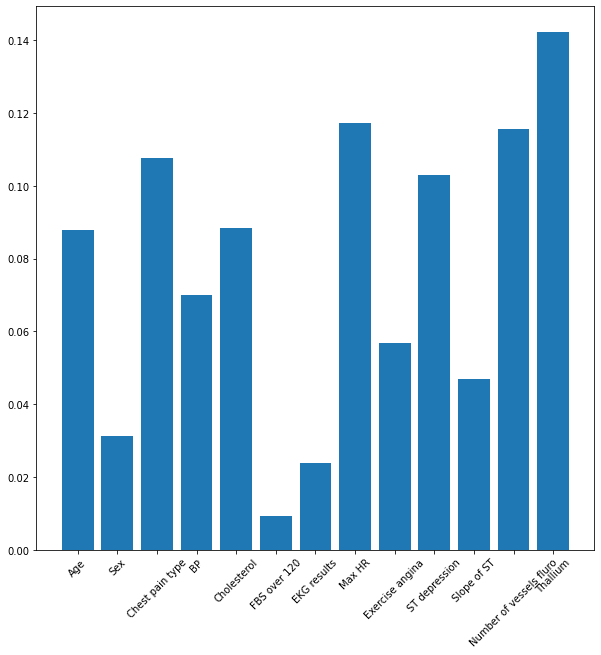

In [33]:
# Feature Selection Using Random Forest
clf = RandomForestClassifier()
clf.fit(df_norm, y)
# Create a figure to plot a bar, where x axis is features, and Y indicating the importance of each feature
plt.figure(figsize=(10,10))
plt.bar(df_norm.columns, clf.feature_importances_)
plt.xticks(rotation=45)

### Solution Implementation

In [34]:
# Let's say we have 4 features: x1, x2, x3, x4
# 1. Function which returns all the possible combinations: E.g.: For 3 features: (x1, x2), (x2, x3), (x1, x3), (x1, x2, x3).
# 2. We Iterate through this list, and for each, we try to find the best oversampler (augmentation method) out of 5-10 oversamplers.
# 2/1. Get the 5 best oversampler for the given dataset.
# 2/2. Try to run 5 oversampler from an array.
# 2/3. Get columns with values
# 2/4. Measure accuracy and score
# 2/5. Later implement new accuracy measures?
# 3. We run RandomForestClassifier and for each itertation, we save the rankings of the features based on importance.
# 3.2. Upon validation we take the same subsets of the validation set!
# 4. Write our own evaulation method: Take the rankings and select the top 3 features (and the best oversampler.)

In [35]:
# 1. Function which returns all the possible combinations: E.g.: For 3 features: (x1, x2), (x2, x3), (x1, x3), (x1, x2, x3).
import itertools
import random

feature_set = df_norm.columns

#Remove this line for proper results
feature_set = random.sample(list(feature_set), 6)

combinations = []
for L in range(4, len(feature_set) + 1):
    for subset in itertools.combinations(feature_set, L):
        combinations.append(subset)
        print(subset)
print(len(combinations))

('Thallium', 'FBS over 120', 'Cholesterol', 'Max HR')
('Thallium', 'FBS over 120', 'Cholesterol', 'EKG results')
('Thallium', 'FBS over 120', 'Cholesterol', 'Chest pain type')
('Thallium', 'FBS over 120', 'Max HR', 'EKG results')
('Thallium', 'FBS over 120', 'Max HR', 'Chest pain type')
('Thallium', 'FBS over 120', 'EKG results', 'Chest pain type')
('Thallium', 'Cholesterol', 'Max HR', 'EKG results')
('Thallium', 'Cholesterol', 'Max HR', 'Chest pain type')
('Thallium', 'Cholesterol', 'EKG results', 'Chest pain type')
('Thallium', 'Max HR', 'EKG results', 'Chest pain type')
('FBS over 120', 'Cholesterol', 'Max HR', 'EKG results')
('FBS over 120', 'Cholesterol', 'Max HR', 'Chest pain type')
('FBS over 120', 'Cholesterol', 'EKG results', 'Chest pain type')
('FBS over 120', 'Max HR', 'EKG results', 'Chest pain type')
('Cholesterol', 'Max HR', 'EKG results', 'Chest pain type')
('Thallium', 'FBS over 120', 'Cholesterol', 'Max HR', 'EKG results')
('Thallium', 'FBS over 120', 'Cholesterol', 'M

In [36]:
# 2/1. Get the 5 best oversampler for the given dataset.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import shutil
import smote_variants as sv
import time

start = time.time()
print("Starting timer")

def handle_chace():
    cache_path = os.path.join(os.path.expanduser('~'), 'smote_tests\smote_test')
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    else:
        shutil.rmtree(cache_path)
    return cache_path

best_5_oversampler = [sv._smote_variants.Borderline_SMOTE1, sv._smote_variants.SPY, sv._smote_variants.Gaussian_SMOTE, sv._smote_variants.SL_graph_SMOTE, sv._smote_variants.SMOTE_TomekLinks]
"""
#This procedure takes approximately 3+ minutes to continue. For the heart_disease dataset, the best 5 oversamplers are the hardcoded ones.

# Selecting the top 5 oversampler
# It is basically brute force so its computation intensive!
oversamplers = sv.get_n_quickest_oversamplers(30)
best_5_oversampler = []

for attempt in range(0, 5):
    cache_path = handle_chace()
    # samp_obj and cl_obj contain the oversampling and classifier objects which give the best performance together
    samp_obj, cl_obj = sv.model_selection(dataset= {'data': df_norm.values, 'target': y, 'name': 'heart_disease_data'},
                                            samplers= oversamplers,
                                            classifiers= [KNeighborsClassifier(), DecisionTreeClassifier()],
                                            cache_path= cache_path,
                                            n_jobs= 5,
                                            max_samp_par_comb= 35)
    best_5_oversampler.append(samp_obj)
    oversamplers.remove(type(samp_obj))
"""
end = time.time()
print("Elapsed time: ", end - start, " seconds")


Starting timer
Elapsed time:  0.0  seconds


In [37]:
#best_5_oversampler = [sv._smote_variants.Borderline_SMOTE1, sv._smote_variants.SPY, sv._smote_variants.Gaussian_SMOTE, sv._smote_variants.SL_graph_SMOTE, sv._smote_variants.SMOTE_TomekLinks]
best_5_oversampler

[smote_variants._smote_variants.Borderline_SMOTE1,
 smote_variants._smote_variants.SPY,
 smote_variants._smote_variants.Gaussian_SMOTE,
 smote_variants._smote_variants.SL_graph_SMOTE,
 smote_variants._smote_variants.SMOTE_TomekLinks]

In [38]:
# For each of the substes we try to find the best oversampler (out of the top 5)
# 2/2. Try to run 5 oversampler from an array.
# 2/3. Get columns with values

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shutil
import smote_variants as sv
import time
import pprint

start = time.time()

# *Option 1*: For every combination, i check which one is the best classifier out of the 5, and rank the importances (set: best rank 1, worst: n)
# Option 2: For every oversampler (5) i run all the combinations, and rank the importances (set: best rank 1, worst: n)
output = []
for combination in combinations:
    cache_path = handle_chace()

    X_train, X_test, y_train, y_test = train_test_split(df_norm[list(combination)].values, y, test_size= 0.25, random_state= 0)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    original_score = clf.score(X_test, y_test)
    #cross_val_score(clf, X_test, y_test, scoring= 'accuracy', cv= RepeatedStratifiedKFold(n_splits= 5, n_repeats= 3, random_state= 1), n_jobs= -1)
    original_feature_importance = clf.feature_importances_


    dataset= {'data': X_train, 'target': y_train, 'name': 'heart_disease_data2'}
    samp_obj, cl_obj = sv.model_selection(dataset= dataset,
                                samplers= [sv._smote_variants.Borderline_SMOTE1],#best_5_oversampler,
                                classifiers= [KNeighborsClassifier(), DecisionTreeClassifier()],
                                cache_path= cache_path,
                                n_jobs= 5,
                                max_samp_par_comb= 35)

    X_samp, y_samp = samp_obj.sample(dataset['data'], dataset['target'])
    print(len(X_train), " - ", len(X_samp))

    clf = RandomForestClassifier()
    clf.fit(X_samp, y_samp)
    score = clf.score(X_test, y_test)
    #cross_val_score(clf, X_test, y_test, scoring= 'accuracy', cv= RepeatedStratifiedKFold(n_splits= 5, n_repeats= 3, random_state= 1), n_jobs= -1)

    feature_importance = clf.feature_importances_

    #TODO delta = set by the user, minimum differece between the two sets
    delta = 0.02
    if round(original_score, 5) + delta < round(score, 5):
        output.append(
            {
                "combination" : combination, 
                "sampler": type(samp_obj),
                "original_feature_importance": original_feature_importance,
                "feature_importance": feature_importance,
                "original_score": original_score,
                "score": score
            })
pprint.pprint(output)

end = time.time()
print("Elapsed time: ", end - start, " seconds, which is: ", (end - start) / 60, " minutes")

ors', 7), ('n_neighbors', 3), ('proportion', 0.75), ('random_state', None)]), 'DecisionTreeClassifier', OrderedDict([('ccp_alpha', 0.0), ('class_weight', None), ('criterion', 'gini'), ('max_depth', None), ('max_features', None), ('max_leaf_nodes', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('random_state', None), ('splitter', 'best')]))"]
["('heart_disease_data2', OrderedDict([('k_neighbors', 3), ('n_neighbors', 7), ('proportion', 0.75), ('random_state', None)]), 'KNeighborsClassifier', OrderedDict([('algorithm', 'auto'), ('leaf_size', 30), ('metric', 'minkowski'), ('metric_params', None), ('n_jobs', None), ('n_neighbors', 5), ('p', 2), ('weights', 'uniform')]))", "('heart_disease_data2', OrderedDict([('k_neighbors', 3), ('n_neighbors', 7), ('proportion', 0.75), ('random_state', None)]), 'DecisionTreeClassifier', OrderedDict([('ccp_alpha', 0.0), ('class_weight', None), ('crit

In [56]:
# 2/4. Measure accuracy and score

#TODO: Draw an evaulation method based on the following: Take into account the occurence of a feature, It's ranking each time, it's importance each time, the accuracy of the model
#In the end, compare: the very first simple oversampled scores, and the augmented scores after feature selection with this method

# Creates dict() with empty array for each feature
scores = { feature_name : { "accuracy_score" : 0, "importance_score" : 0, "feature_appearence" : 0 } for feature_name in df_norm.columns }
# Creates dict() with every sampler used, initialized with 0 value for counting
model_counter = { model_name : 0 for model_name in best_5_oversampler }
    

def increase_model_count(model):
    model_counter[model] += 1

def evaulation(results):
    

    print(scores)


evaulation(output)

{'Age': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Sex': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Chest pain type': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'BP': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Cholesterol': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'FBS over 120': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'EKG results': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Max HR': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Exercise angina': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'ST depression': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Slope of ST': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearence': 0}, 'Number of vessels fluro': {'accuracy_score': 0, 'importance_score': 0, 

In [41]:
"""
[{'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'Max HR',
                  'EKG results'),
  'feature_importance': array([0.32449936, 0.23734313, 0.39282751, 0.04533   ]),
  'original_feature_importance': array([0.32451913, 0.2347048 , 0.39415311, 0.04662296]),
  'original_score': 0.6617647058823529,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6911764705882353},
 {'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'BP',
                  'EKG results'),
  'feature_importance': array([0.41515951, 0.24347137, 0.29461296, 0.04675617]),
  'original_feature_importance': array([0.41282495, 0.26448017, 0.27747918, 0.04521571]),
  'original_score': 0.6323529411764706,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6617647058823529},
 {'combination': ('Cholesterol', 'BP', 'EKG results', 'Age'),
  'feature_importance': array([0.3590297 , 0.25088046, 0.04834042, 0.34174942]),
  'original_feature_importance': array([0.37262486, 0.24379154, 0.05471911, 0.32886448]),
  'original_score': 0.5441176470588235,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.5735294117647058},
 {'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'Max HR',
                  'BP',
                  'Age'),
  'feature_importance': array([0.19281611, 0.18608848, 0.26819943, 0.14842081, 0.20447517]),
  'original_feature_importance': array([0.18316729, 0.19204859, 0.28505088, 0.13652708, 0.20320616]),
  'original_score': 0.6470588235294118,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6764705882352942},
 {'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'BP',
                  'EKG results',
                  'Age'),
  'feature_importance': array([0.27816127, 0.21461498, 0.19773347, 0.04411246, 0.26537782]),
  'original_feature_importance': array([0.26982414, 0.23643601, 0.18661623, 0.04343062, 0.263693  ]),
  'original_score': 0.6470588235294118,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6911764705882353}]
  """

"\n[{'combination': ('Cholesterol',\n                  'Number of vessels fluro',\n                  'Max HR',\n                  'EKG results'),\n  'feature_importance': array([0.32449936, 0.23734313, 0.39282751, 0.04533   ]),\n  'original_feature_importance': array([0.32451913, 0.2347048 , 0.39415311, 0.04662296]),\n  'original_score': 0.6617647058823529,\n  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,\n  'score': 0.6911764705882353},\n {'combination': ('Cholesterol',\n                  'Number of vessels fluro',\n                  'BP',\n                  'EKG results'),\n  'feature_importance': array([0.41515951, 0.24347137, 0.29461296, 0.04675617]),\n  'original_feature_importance': array([0.41282495, 0.26448017, 0.27747918, 0.04521571]),\n  'original_score': 0.6323529411764706,\n  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,\n  'score': 0.6617647058823529},\n {'combination': ('Cholesterol', 'BP', 'EKG results', 'Age'),\n  'featu